In [1]:
import warnings
import ast
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

warnings.filterwarnings("ignore")

In [2]:
PROJECT_NAME = "flink"
EXP_ID = "apch"
MODEL_HISTORY = 15
TOTAL_WINDOWS = 54
ALPHA = 0.05

DATA_DIR = Path().cwd() / "ecoselekt" / "data"
MODELS_DIR = Path().cwd() / "ecoselekt" / "models"
RESULTS_DIR = Path().cwd() / "results" / f"exp_{EXP_ID}"
FIGURES_DIR = Path().cwd() / "figures"

DATA_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
# load baseline evaluation results
base_eval_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_base_eval.csv")
base_eval_df["model"] = "base"
base_eval_df.head()

,project,window,test_split,precision,recall,f1,auc,gmean,ap,specifi,model
0,flink,0,1,0.0,0.0,0.0,0.974874,0.0,0.166667,1.000000,base
1,flink,0,2,0.0,0.0,0.0,-1.000000,1.0,-0.000000,0.000000,base
2,flink,0,3,0.0,0.0,0.0,0.916667,0.0,0.105263,1.000000,base
3,flink,0,4,0.0,0.0,0.0,0.928219,0.0,0.542448,0.994652,base
4,flink,0,5,0.0,0.0,0.0,0.181895,0.0,0.012469,1.000000,base


In [4]:
# load ecoselekt evaluation results
selekt_eval_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_selekt_eval.csv")
selekt_eval_df["model"] = "ecoselekt"
selekt_eval_df.head()

,project,window,test_split,precision,recall,f1,auc,gmean,ap,specifi,model
0,flink,15,16,0.500000,0.123596,0.198198,0.593177,0.333687,0.505634,0.900901,ecoselekt
1,flink,15,17,0.531250,0.151786,0.236111,0.580814,0.354842,0.603422,0.829545,ecoselekt
2,flink,15,18,0.525000,0.194444,0.283784,0.505334,0.392794,0.547370,0.793478,ecoselekt
3,flink,15,19,0.605263,0.214953,0.317241,0.617224,0.424598,0.630323,0.838710,ecoselekt
4,flink,15,20,0.607143,0.180851,0.278689,0.603623,0.402596,0.573303,0.896226,ecoselekt


In [5]:
# load best select evaluation results
best_eval_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_best_eval.csv")
best_eval_df["model"] = "best"
best_eval_df.head()

,project,window,test_split,precision,recall,f1,auc,gmean,ap,specifi,model
0,flink,15,16,1.0,0.797753,0.887500,0.999899,0.893170,0.999875,1.0,best
1,flink,15,17,1.0,0.723214,0.839378,0.999696,0.850420,0.999761,1.0,best
2,flink,15,18,1.0,0.666667,0.800000,1.000000,0.816497,1.000000,1.0,best
3,flink,15,19,1.0,0.682243,0.811111,1.000000,0.825980,1.000000,1.0,best
4,flink,15,20,1.0,0.627660,0.771242,0.999548,0.792250,0.999435,1.0,best


(1482, 11)


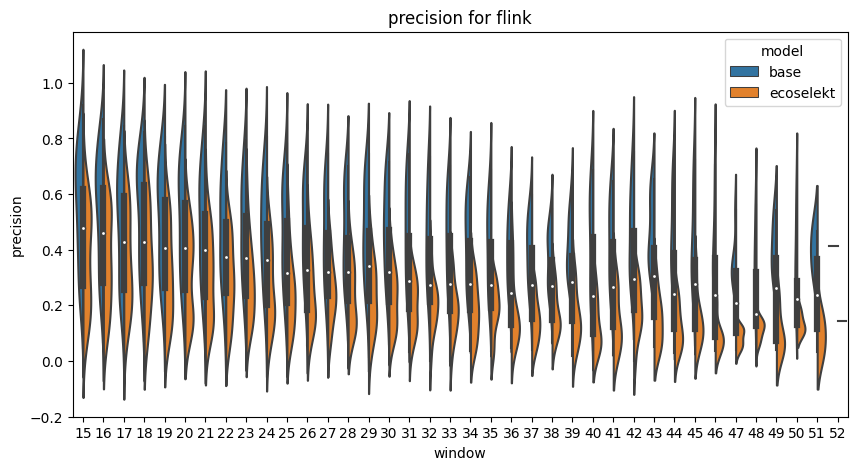

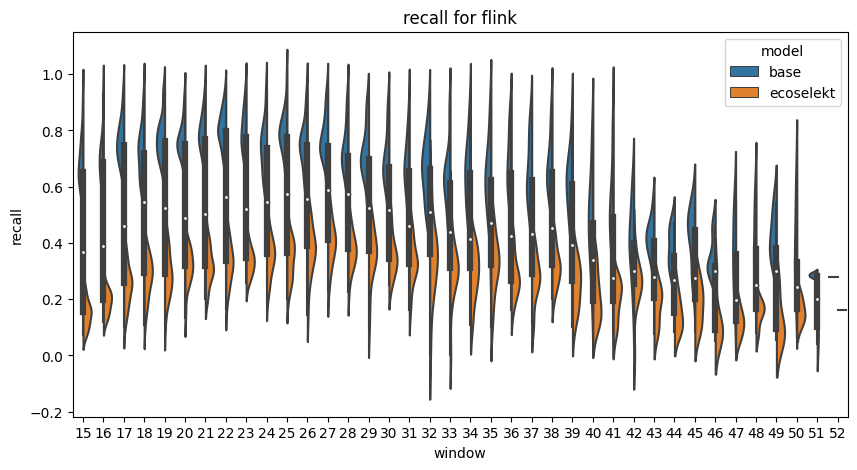

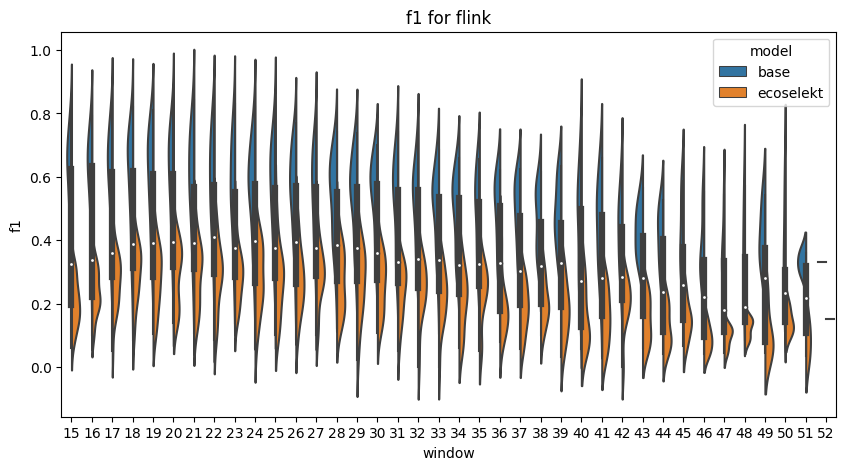

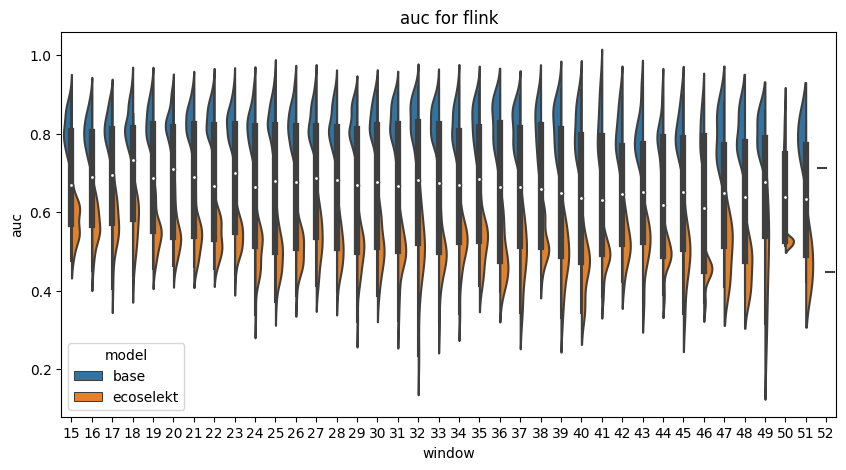

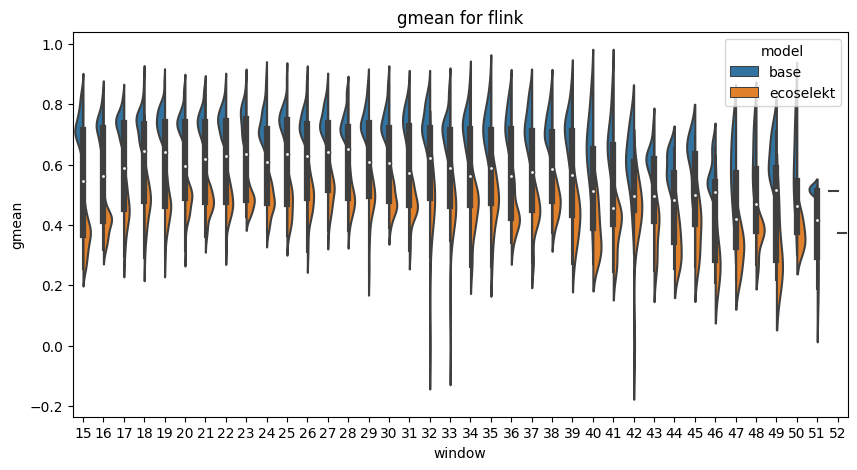

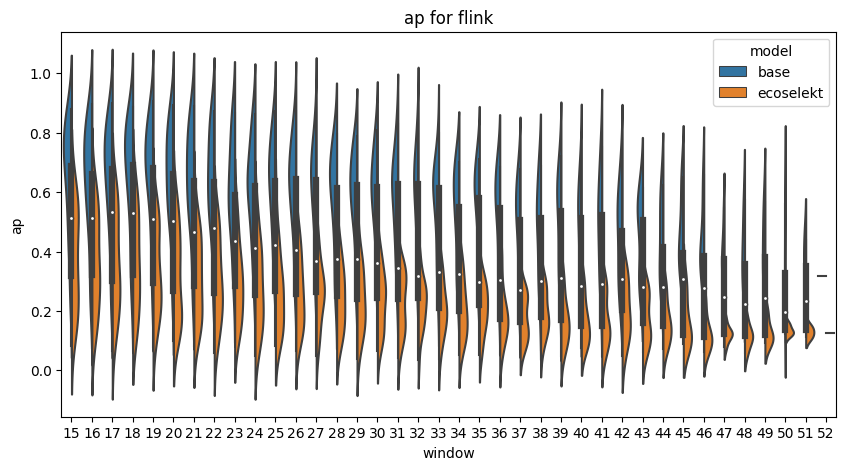

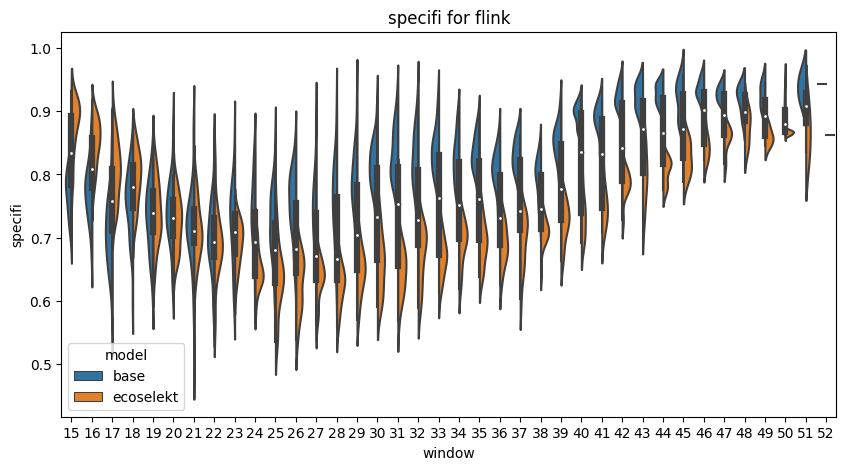

In [6]:
# concat base and ecoselekt evaluation dataframes keeping only common `window` and `test_split` then plot violin plots for each metric
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], selekt_eval_df])
print(eval_df.shape)

# plot violin plots for each metric
for metric in ["precision", "recall", "f1", "auc", "gmean", "ap", "specifi"]:
    plt.figure(figsize=(10, 5))
    sns.violinplot(x="window", y=metric, data=eval_df, hue="model", split=True)
    plt.title(f"{metric} for {PROJECT_NAME}")
    plt.show()


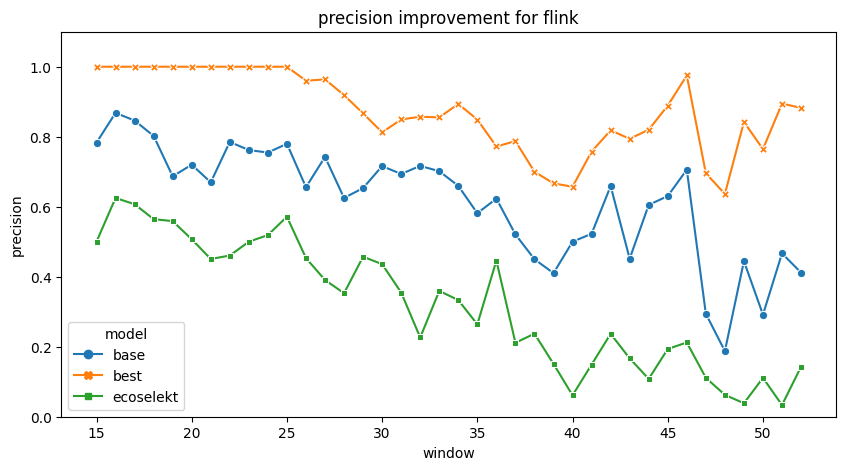

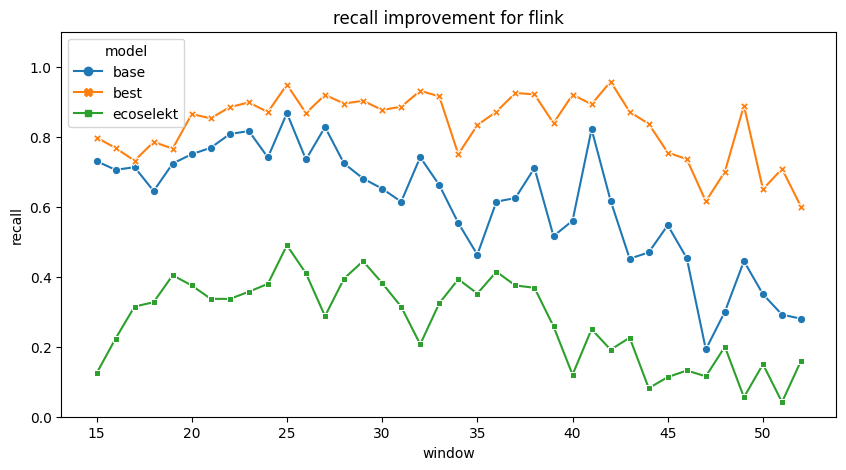

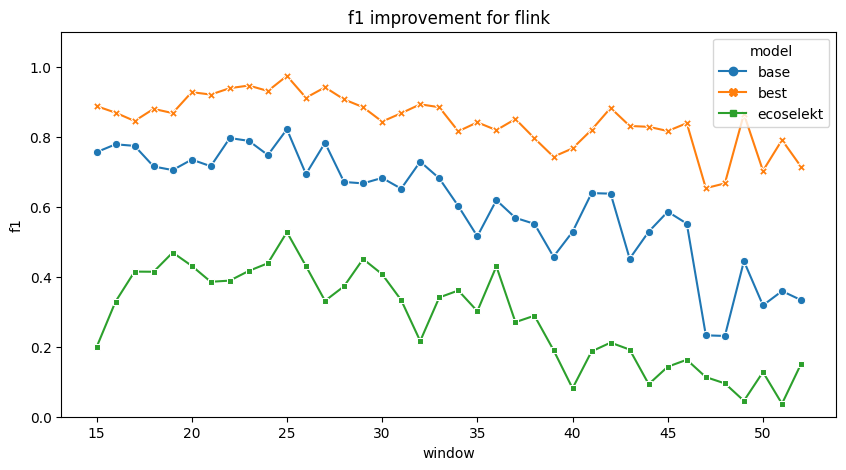

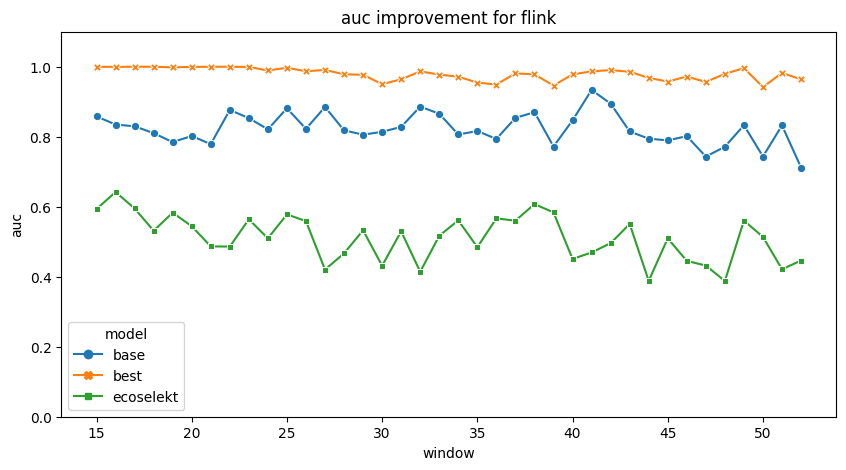

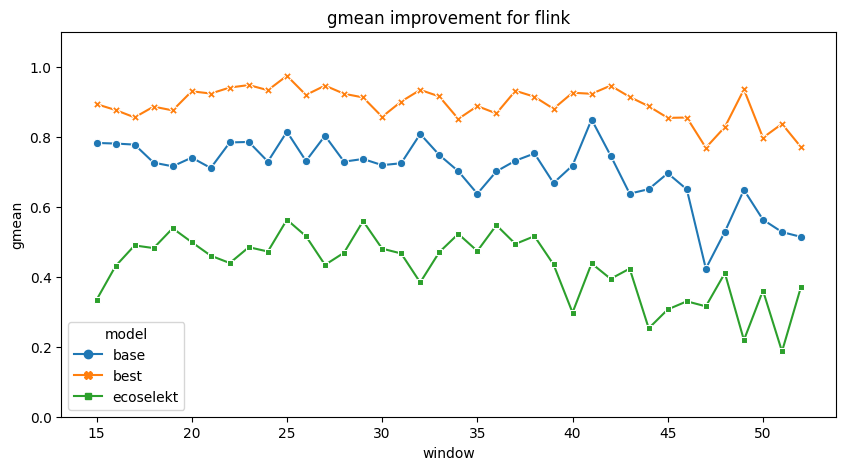

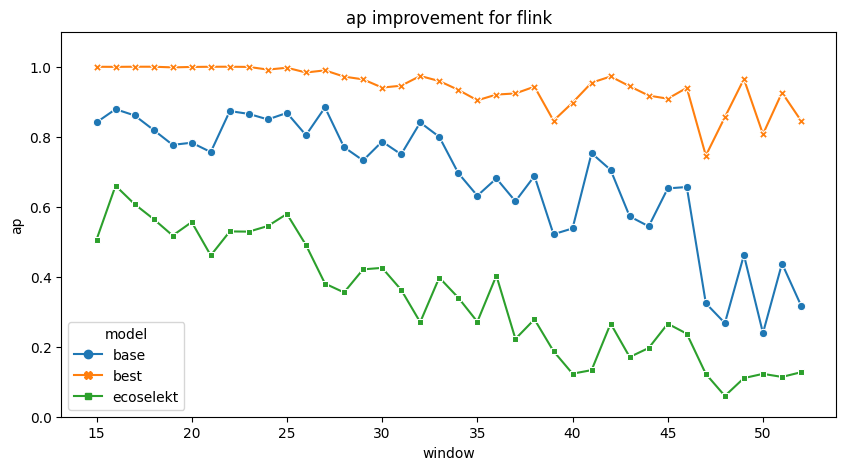

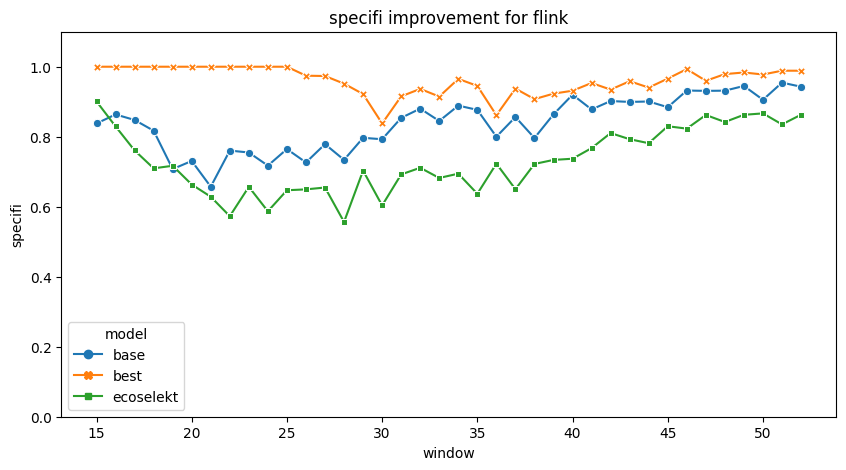

In [7]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], best_eval_df, selekt_eval_df])
eval_df = eval_df[eval_df["window"] == eval_df["test_split"] - 1]
# plot percetange improvement for each metric for each window
for metric in ["precision", "recall", "f1", "auc", "gmean", "ap", "specifi"]:
    plt.figure(figsize=(10, 5))
    sns.lineplot(x="window", y=metric, data=eval_df, hue="model", markers=True, style="model", dashes=False)
    plt.title(f"{metric} improvement for {PROJECT_NAME}")
    plt.ylim(0, 1.1)
    plt.show()

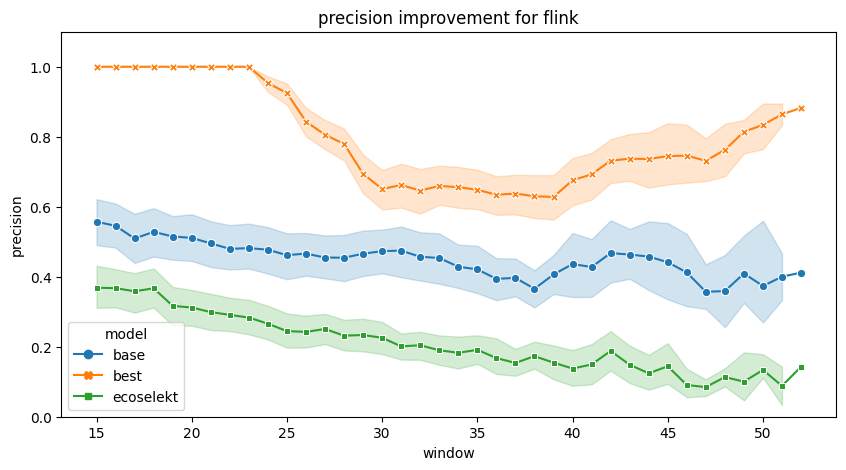

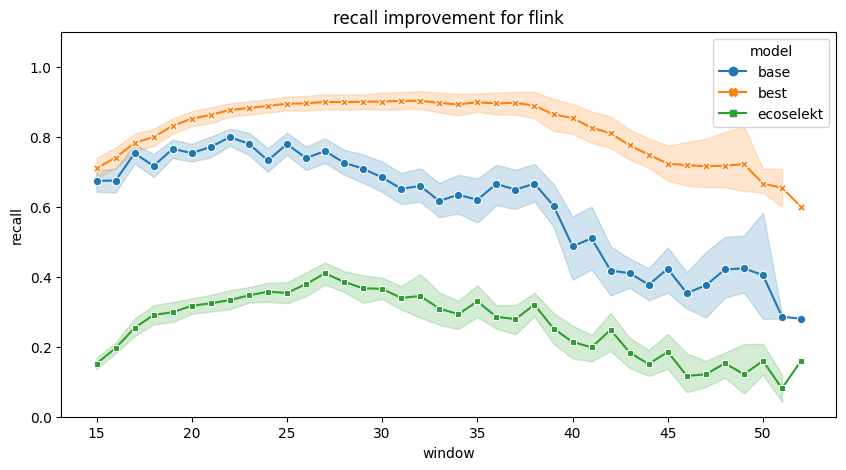

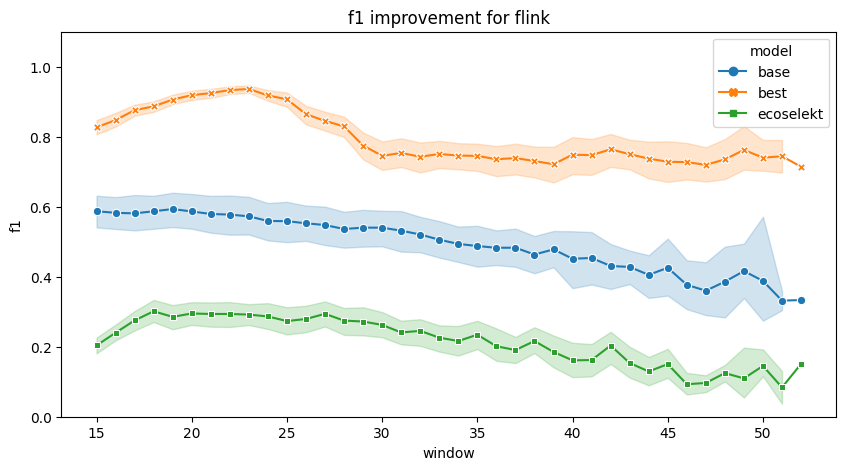

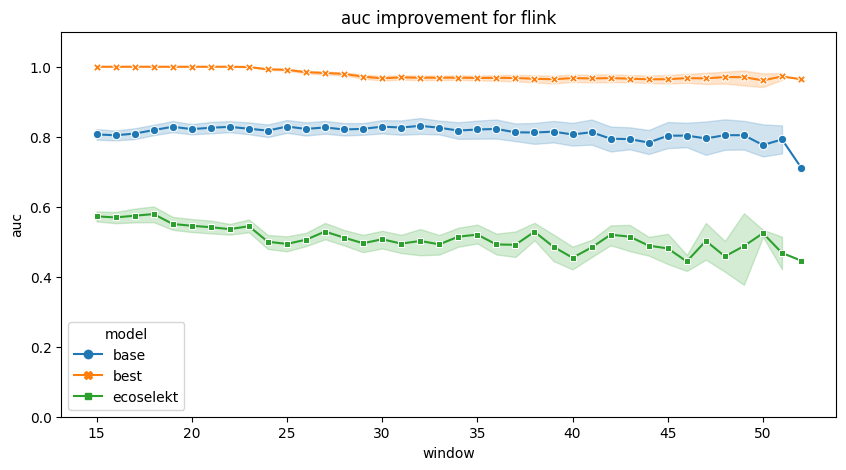

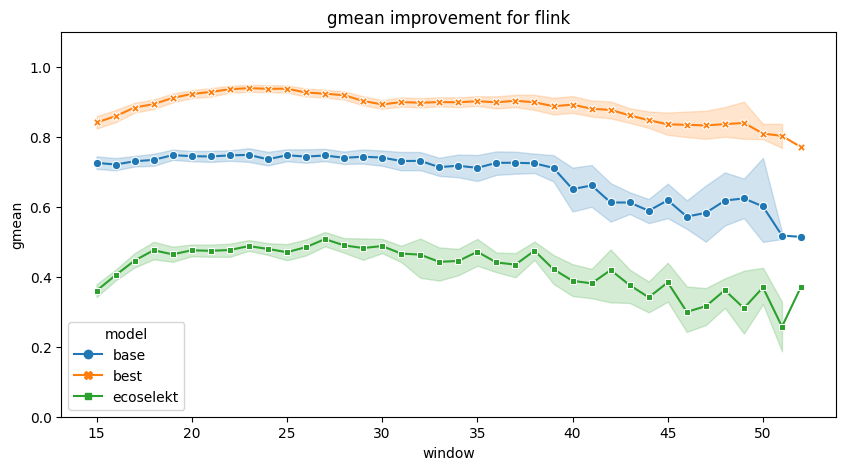

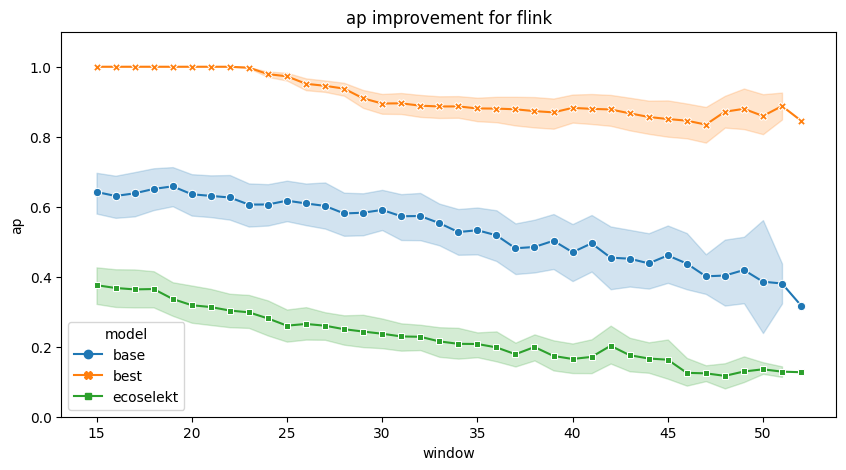

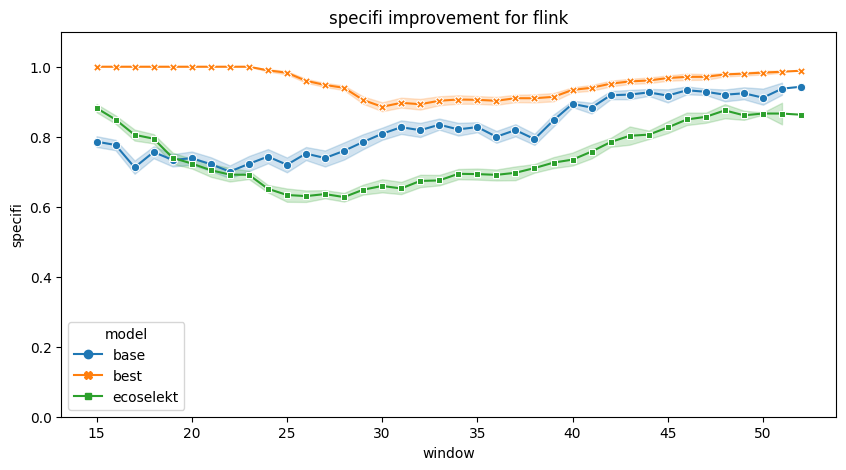

In [8]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], best_eval_df, selekt_eval_df])
# plot percetange improvement for each metric for each window
for metric in ["precision", "recall", "f1", "auc", "gmean", "ap", "specifi"]:
    plt.figure(figsize=(10, 5))
    sns.lineplot(x="window", y=metric, data=eval_df, hue="model", markers=True, style="model", dashes=False)
    plt.title(f"{metric} improvement for {PROJECT_NAME}")
    plt.ylim(0, 1.1)
    plt.show()

In [9]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], selekt_eval_df])
eval_df = eval_df[eval_df["window"] == eval_df["test_split"] - 1]
_, p = wilcoxon(eval_df[eval_df["model"] == "ecoselekt"]["auc"], eval_df[eval_df["model"] == "base"]["auc"])
print(f"Wilcoxon test p-value: {p}")
print(f"Wilcoxon test significance: {p < ALPHA}")

Wilcoxon test p-value: 7.275957614183426e-12
Wilcoxon test significance: True


In [10]:
eval_df = pd.concat([base_eval_df[base_eval_df["window"] >= MODEL_HISTORY], selekt_eval_df])
eval_df = eval_df[eval_df["window"] == eval_df["test_split"] - 1]
_, p = wilcoxon(eval_df[eval_df["model"] == "ecoselekt"]["recall"], eval_df[eval_df["model"] == "base"]["recall"])
print(f"Wilcoxon test p-value: {p}")
print(f"Wilcoxon test significance: {p < ALPHA}")

Wilcoxon test p-value: 7.275957614183426e-12
Wilcoxon test significance: True


In [11]:
bestmodel_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_best_model_per_test_split.csv")
bestmodel_df.drop(columns=["Unnamed: 0"], inplace=True)
print(bestmodel_df.shape)
bestmodel_df.head()

(148200, 4)


,commit_id,window,test_split,model_version
0,858d1bccf957bf36c04ab011ec9a26933109086c,15,16,5
1,3f74e0597e62e0392dae337ca26d107538544513,15,16,3
2,99544bd9000eebe468a721b0bcf06d3e387fdacf,15,16,5
3,98ff76b0ea61a342250e15411edd9f7974cbe96d,15,16,5
4,d57a9d7ab59243e78836fb7bd4120106071a3d49,15,16,6


In [12]:
selektmodel_df = pd.read_csv(RESULTS_DIR / f"{EXP_ID}_{PROJECT_NAME}_selected_model_per_test_split.csv")
selektmodel_df.drop(columns=["Unnamed: 0"], inplace=True)
print(selektmodel_df.shape)
selektmodel_df.head()

(148200, 4)


,commit_id,window,test_split,model_version
0,0190dd24622169a98be1a6ef518b0fdd018e2d44,15,16,11
1,024d744258697b28011836f78cd3a6a79d8281a8,15,16,5
2,0297d60c87aa029c24b10f2be4044cebe4c3300d,15,16,12
3,02e2857a94adc7e427f36180542196331e8ae871,15,16,10
4,034854db3eef60bc6247fabdc0172d2bc8c4496a,15,16,5


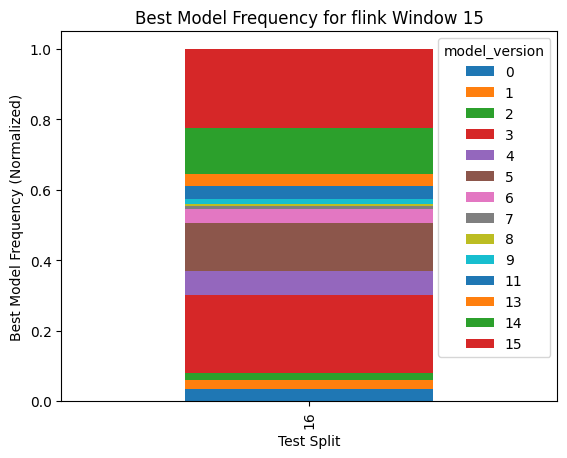

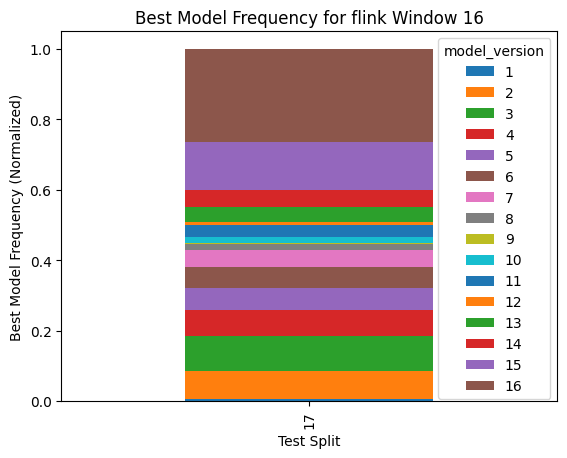

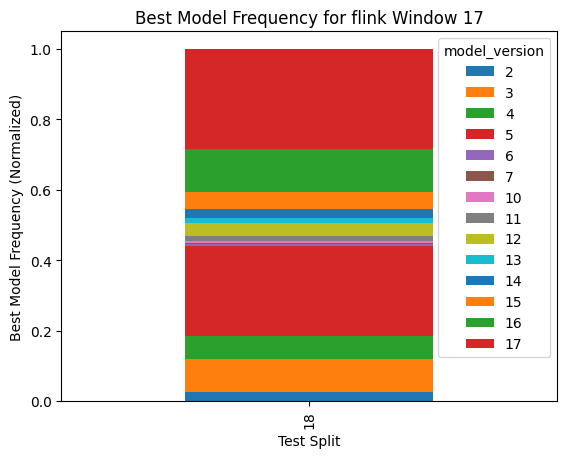

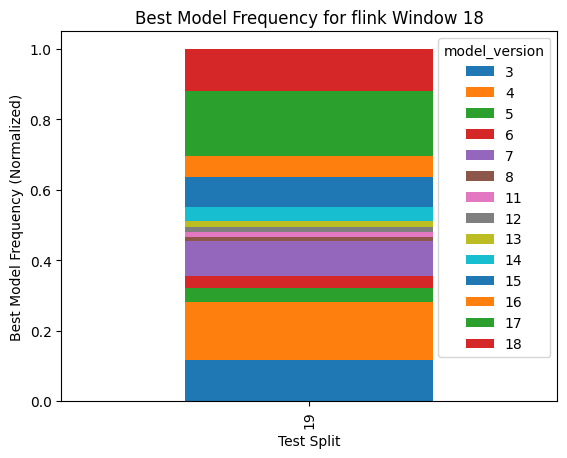

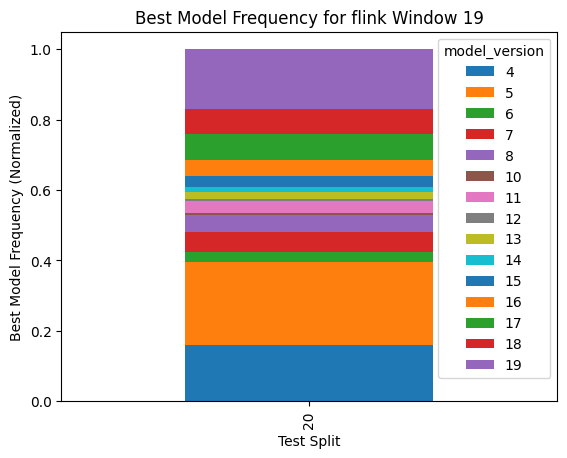

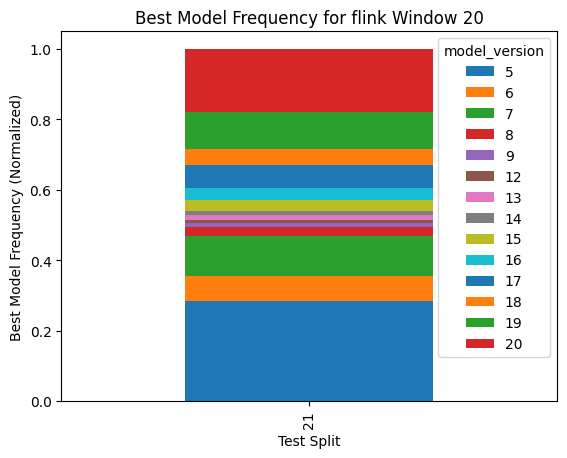

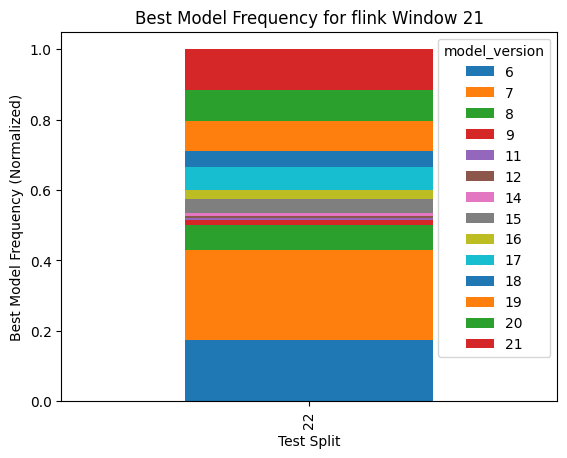

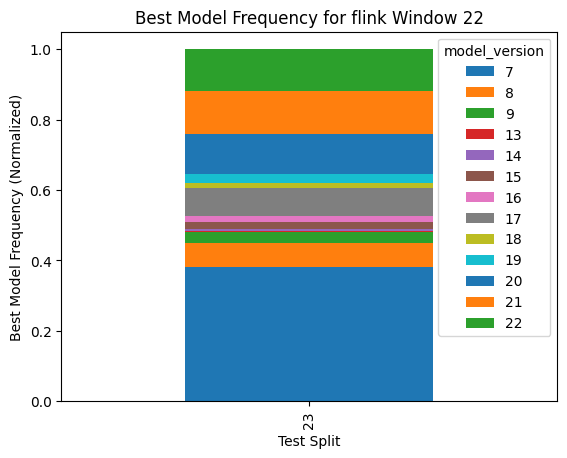

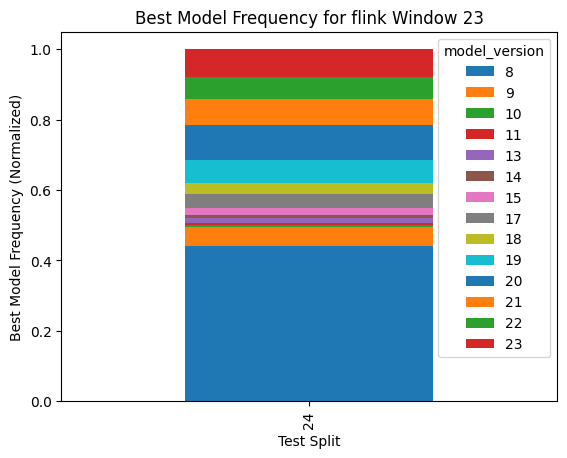

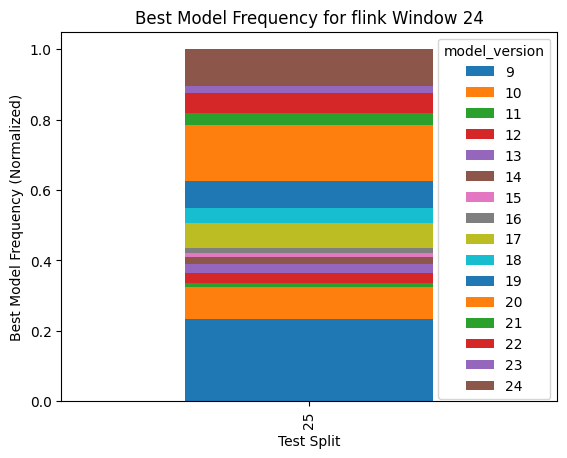

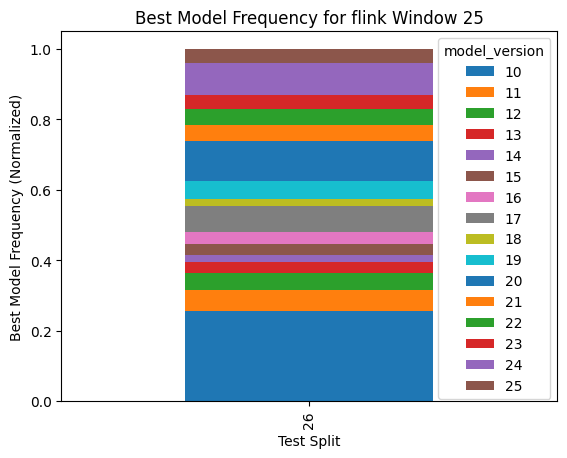

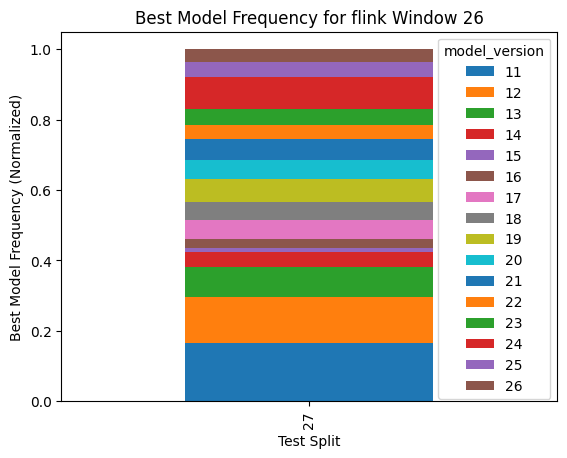

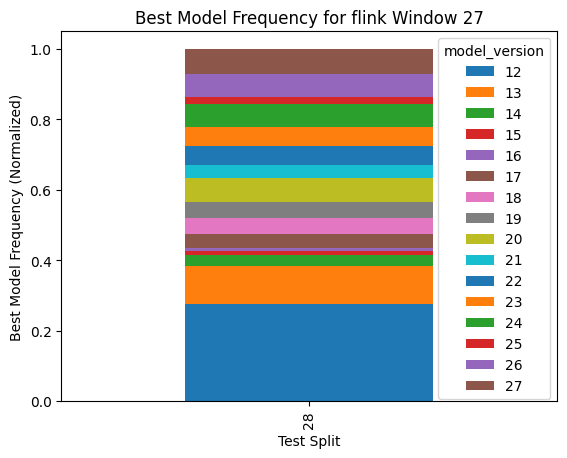

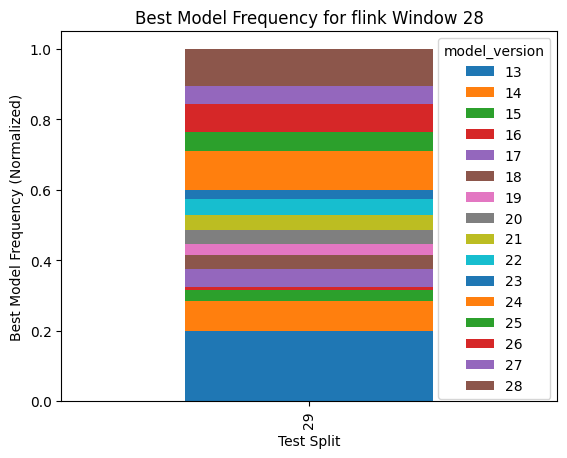

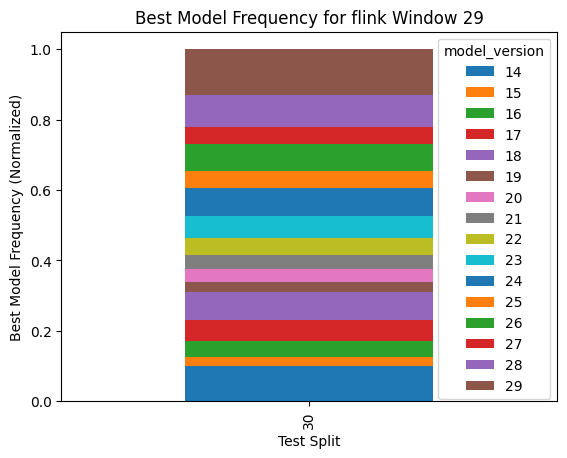

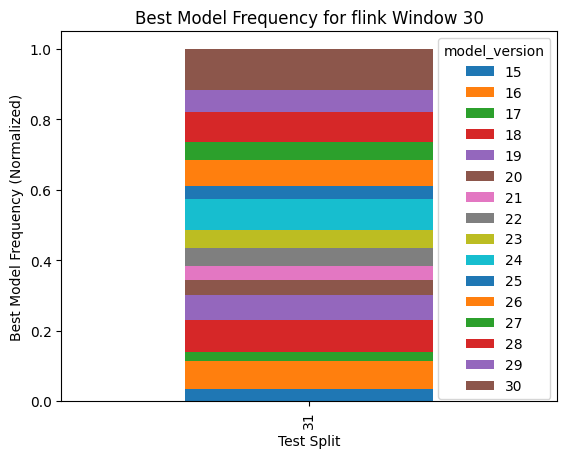

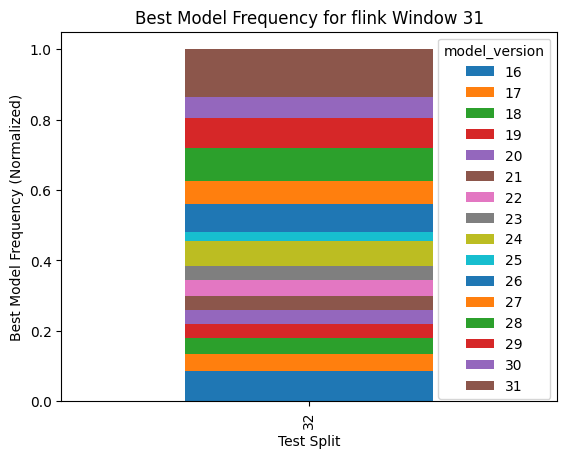

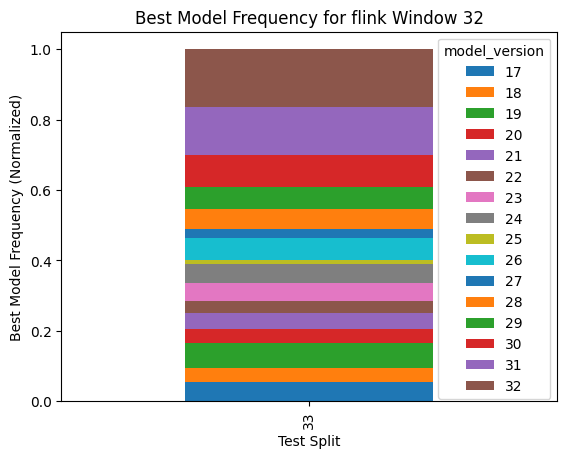

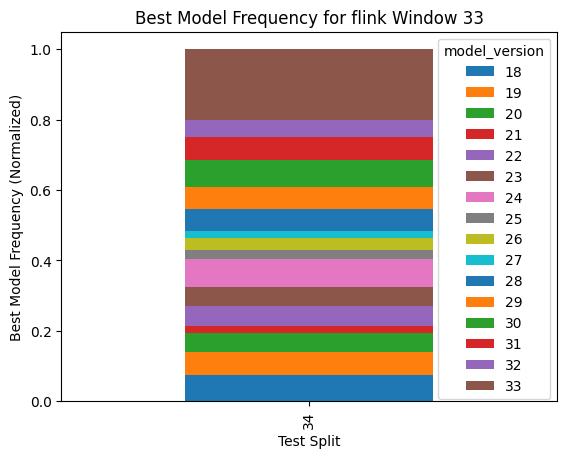

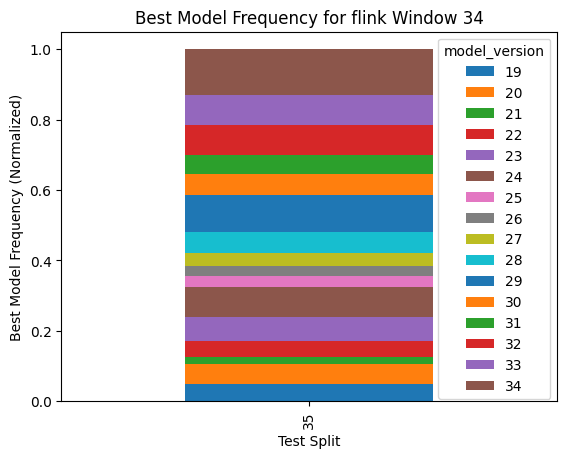

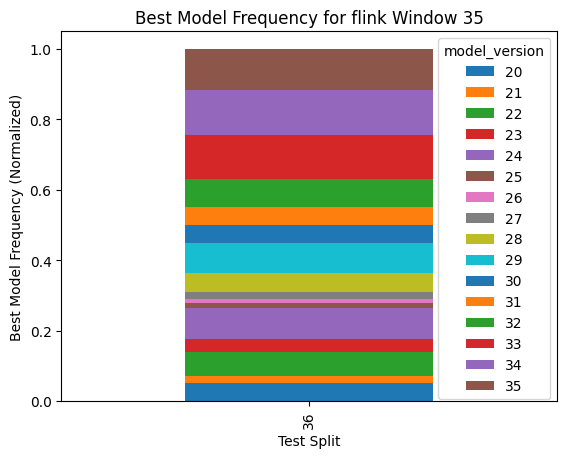

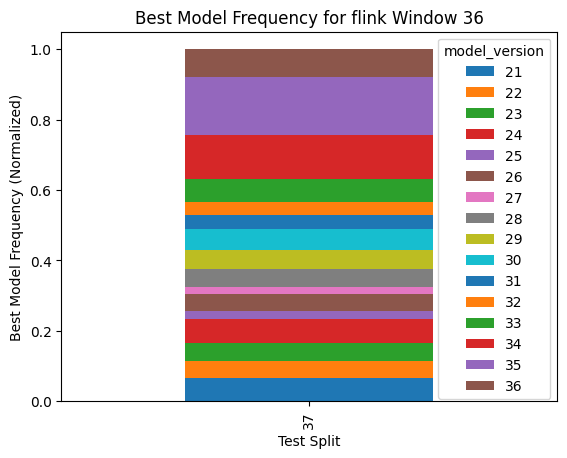

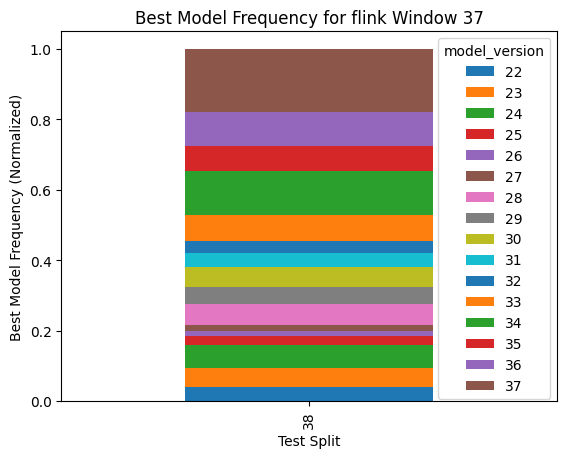

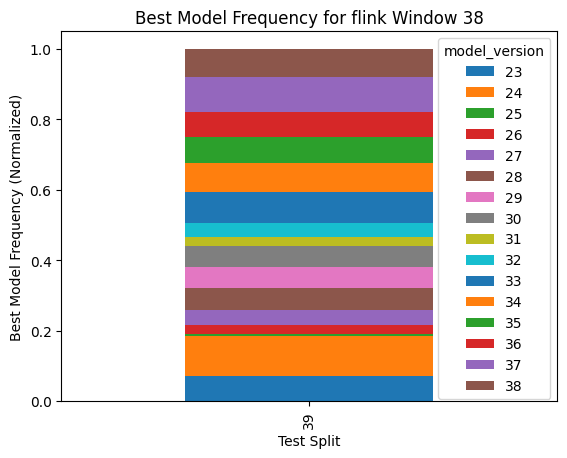

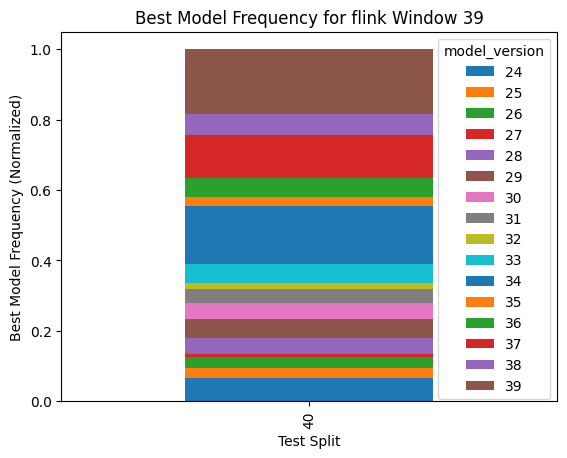

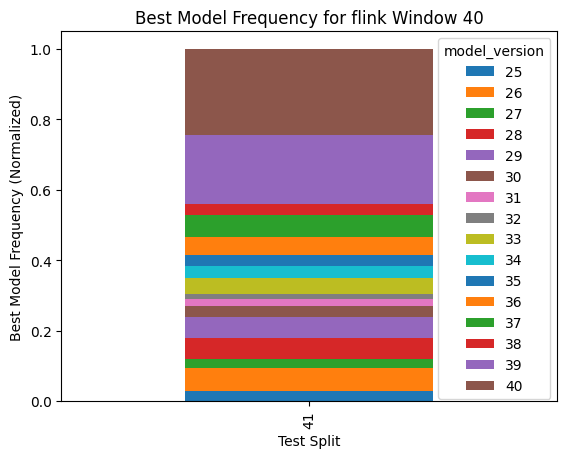

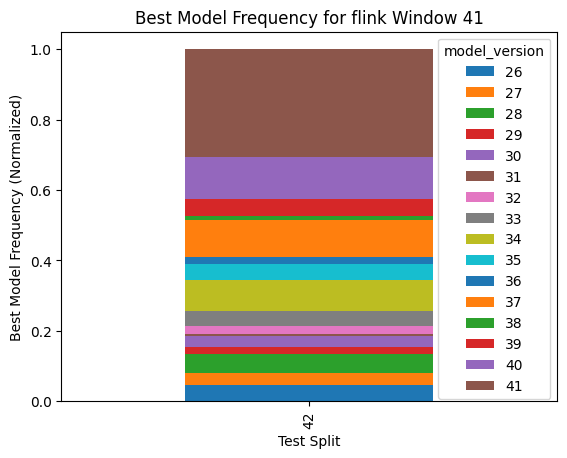

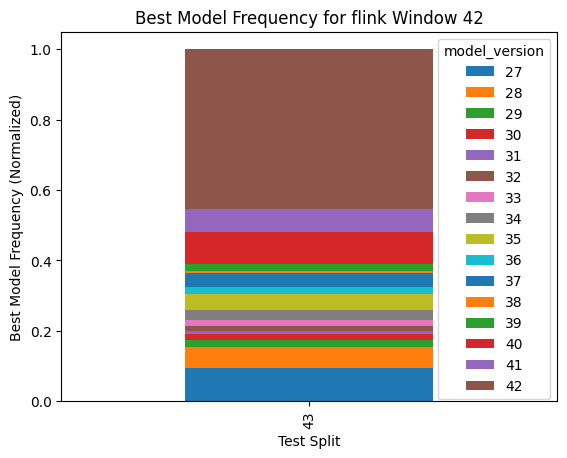

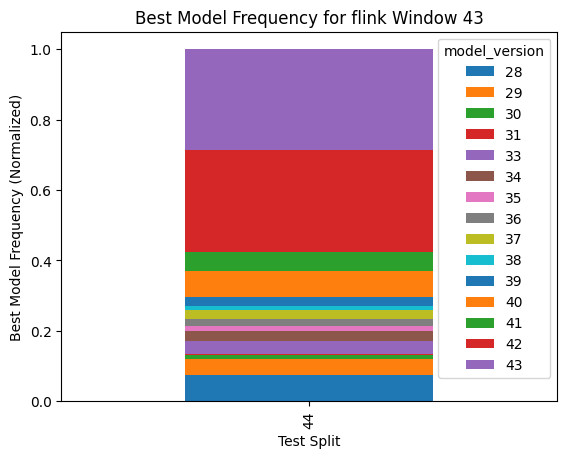

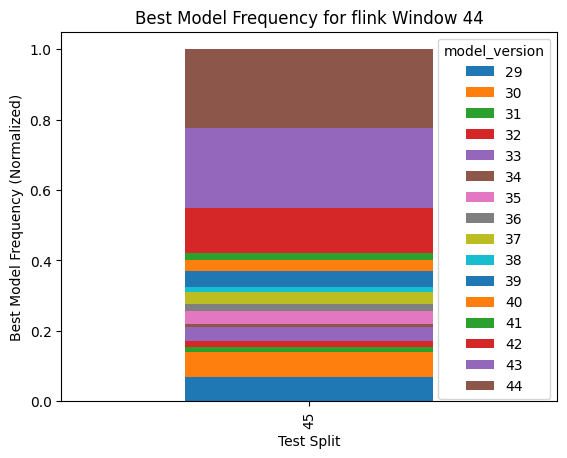

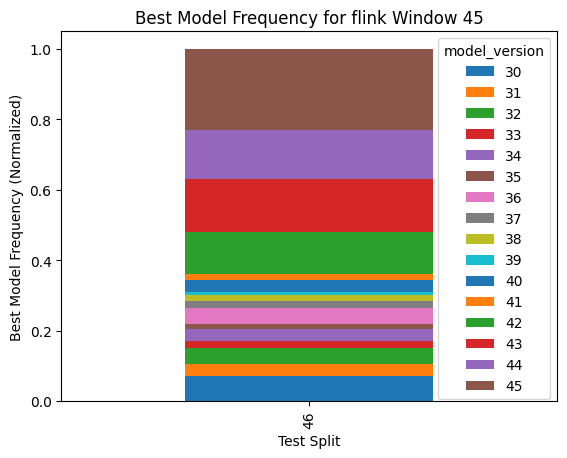

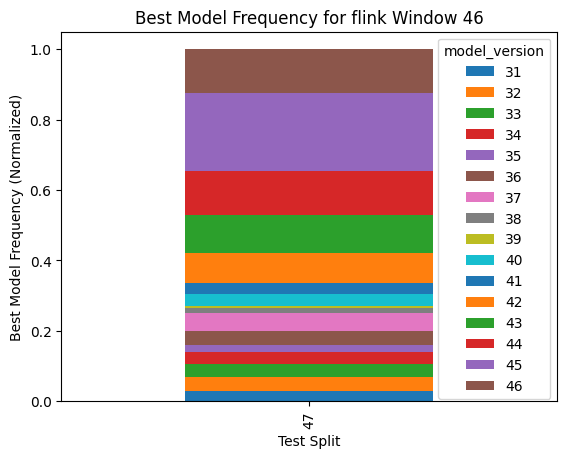

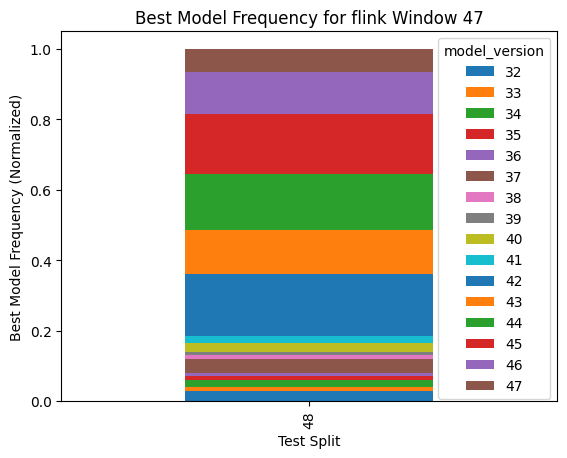

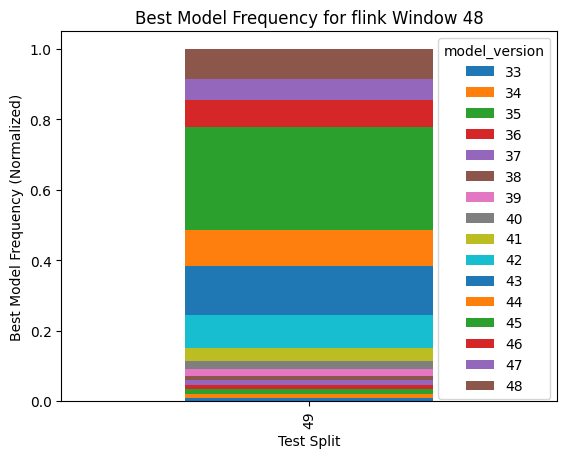

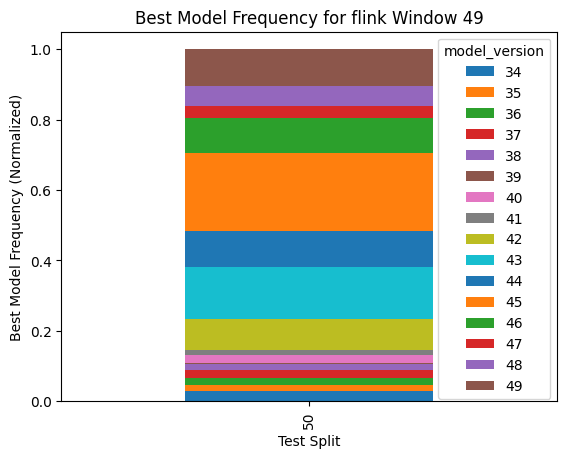

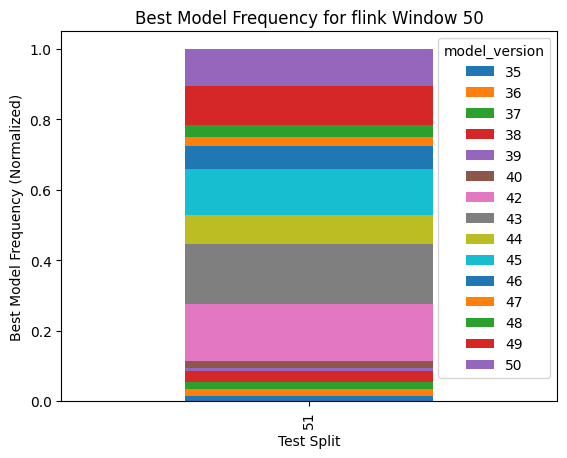

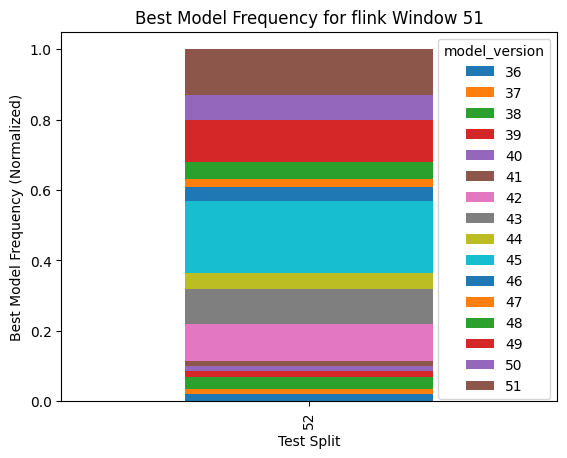

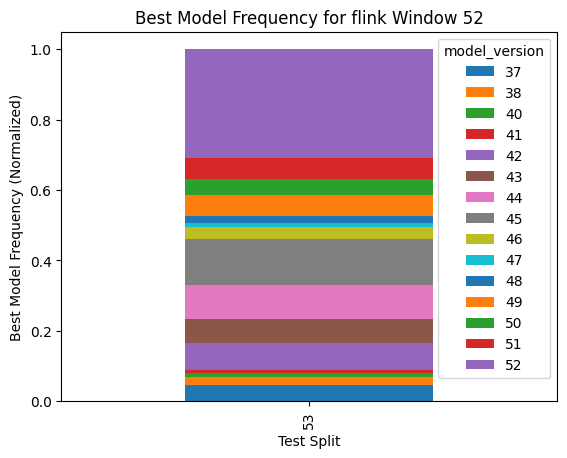

In [13]:
for i in range(MODEL_HISTORY,TOTAL_WINDOWS - 1):
    temp_bestmodel_df = bestmodel_df[bestmodel_df["window"] == i]
    temp_bestmodel_df = temp_bestmodel_df[temp_bestmodel_df["test_split"] == i + 1]

    # best model
    model_frequency_by_test_split = temp_bestmodel_df.groupby('test_split')['model_version'].value_counts().unstack().fillna(0)
    normalized_model_frequency_by_test_split = model_frequency_by_test_split.div(model_frequency_by_test_split.sum(axis=1), axis=0)
    p = normalized_model_frequency_by_test_split.plot(kind='bar', stacked=True)
    p.set_xlabel("Test Split")
    p.set_ylabel("Best Model Frequency (Normalized)")
    p.set_title(f"Best Model Frequency for {PROJECT_NAME} Window {i}")